## 개요

Imagen 4 를 활용한 이미지 생성 사례를 탐색.

구글 클라우드 교육에 사용되는 노트북 코드를 기반으로 작성.

### 사용 LLM: Imagen 4, Imagen 4 Fast 및 Imagen 4 Ultra 모델

### 목표

Python용 Gen AI SDK를 사용하여 아래의 방식을 테스트.

- 스타일 다양성
- 다국어 프롬프트 지원 및 향상
- 고품질 사실적 표현
- 텍스트 렌더링
- 이미지 워터마킹

## 시작


In [1]:
from google import genai
import os
from dotenv import load_dotenv
from IPython.display import Audio, Image, Markdown, Video, display
from google.genai.types import GenerateImagesConfig

load_dotenv()

PROJECT_ID = os.getenv("VERTEXAI_PROJECT_ID")
LOCATION = os.getenv("VERTEXAI_LOCATION")
credential_path = os.getenv("VERTEXAI_CREDENTIALS_PATH")

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = credential_path

client = genai.Client(
    vertexai=True,
    project=PROJECT_ID,
    location=LOCATION,
)

generation_model = "imagen-4.0-generate-001"
generation_model_fast = "imagen-4.0-fast-generate-001"
generation_model_ultra = "imagen-4.0-ultra-generate-001"

### 이미지를 표시하는 도우미 함수 정의

In [2]:
import typing

import IPython.display
from PIL import Image as PIL_Image
from PIL import ImageOps as PIL_ImageOps


def display_image(
    image,
    max_width: int = 700,
    max_height: int = 400,
) -> None:
    pil_image = typing.cast(PIL_Image.Image, image._pil_image)
    if pil_image.mode != "RGB":
        # RGB is supported by all Jupyter environments (e.g. RGBA is not yet)
        pil_image = pil_image.convert("RGB")
    image_width, image_height = pil_image.size
    if max_width < image_width or max_height < image_height:
        # Resize to display a smaller notebook image
        pil_image = PIL_ImageOps.contain(pil_image, (max_width, max_height))
    IPython.display.display(pil_image)

### 1. Imagen 4 테스트

Imagen 4 모델 탐구
- 텍스트 렌더링 기능: 사용자가 생성할 이미지에 렌더링 시킬 텍스트를 `prompt`로 작성
- 매개변수 설명(공통)
    - `aspect_ratio`: 가로세로 비율 구성(1:1, 9:16, 16:9, 3:4, 4:3)
    - `number_of_images`: 생성할 이미지 개수(1~4개 사잇값)
    - `image_size`: 이미지 크기 설정(1K 또는 2K)
    - `person_generation`: 인물 이미지 생성에 대한 설정(DONT_ALLOW, ALLOW_ADULT, ALLOW_ALL)
    - `safety_filter_level`: 안전 필터 레벨 설정(BLOCK_LOW_AND_ABOVE, BLOCK_MEDIUM_AND_ABOVE, BLOCK_ONLY_HIGH, BLOCK_NONE)

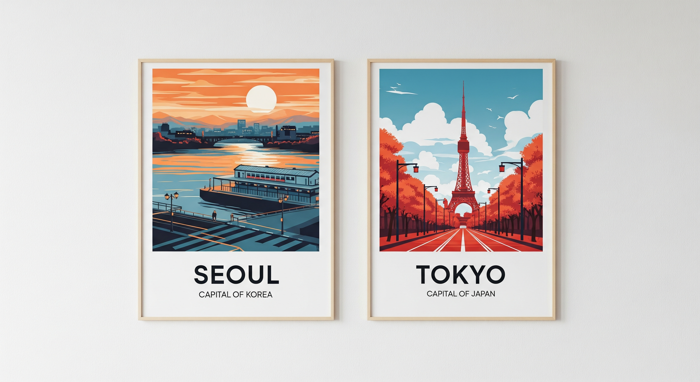

In [ ]:
prompt = """
흰 벽에 두 개의 관광지 포스터가 걸려 있다.
- 첫 번째 포스터에는 "서울"이라는 텍스트와 "한국의 수도"라는 태그라인이 있고
- 두 번째 포스터에는 "도툐"라는 텍스트와 "일본의 수도"라는 태그라인이 있다.
"""

image = client.models.generate_images(
    model=generation_model,
    prompt=prompt,
    config=GenerateImagesConfig(
        aspect_ratio="16:9",
        number_of_images=1,
        image_size="2K",
        safety_filter_level="BLOCK_MEDIUM_AND_ABOVE",
        person_generation="ALLOW_ADULT",
    ),
)

display_image(image.generated_images[0].image)

### 2. Imagen 4 Fast 모델과의 비교 테스트

**Imagen 4**: 자연스러운 조명과 향상된 사실적 표현으로 고품질 이미지를 생성
**Imagen 4 Fast**: 더 높은 대비를 가진 밝은 이미지를 만드는 데 적합

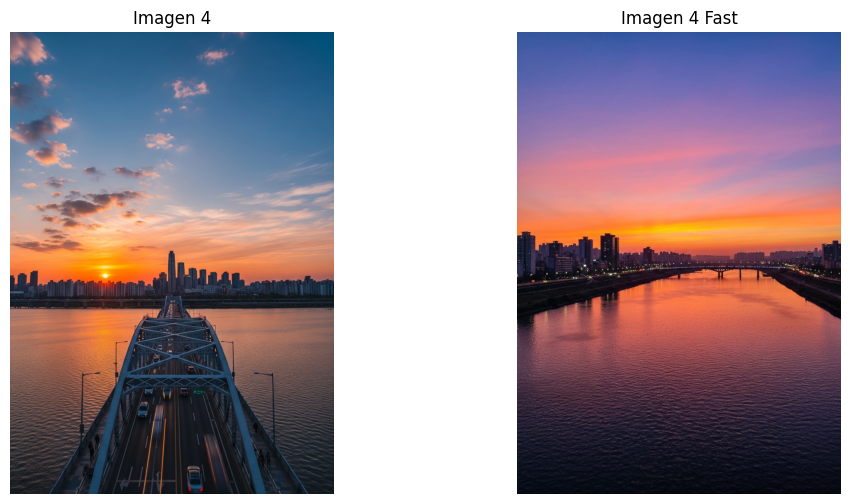

In [7]:
import matplotlib.pyplot as plt

prompt = """
대교 위에서 바라본 일몰 때의 한강.
"""

# Imagen 4 image generation
image = client.models.generate_images(
    model=generation_model,
    prompt=prompt,
    config=GenerateImagesConfig(
        number_of_images=1,
        aspect_ratio="3:4",
        image_size="2K",
        safety_filter_level="BLOCK_LOW_AND_ABOVE",
        person_generation="ALLOW_ALL",
    ),
)

# Imagen 4 Fast image generation
fast_image = client.models.generate_images(
    model=generation_model_fast,
    prompt=prompt,
    config=GenerateImagesConfig(
        number_of_images=1,
        aspect_ratio="3:4",
        image_size="2K",
        safety_filter_level="BLOCK_LOW_AND_ABOVE",
        person_generation="ALLOW_ALL",
    ),
)

# Display generated images
fig, axis = plt.subplots(1, 2, figsize=(12, 6))
axis[0].imshow(image.generated_images[0].image._pil_image)
axis[0].set_title("Imagen 4")
axis[1].imshow(fast_image.generated_images[0].image._pil_image)
axis[1].set_title("Imagen 4 Fast")
for ax in axis:
    ax.axis("off")
plt.show()

### 3. Imagen 4 Ultra의 고품질 이미지 테스트

Imagen 4 Ultra 모델은 지연 시간을 절충하여 매우 높은 품질의 이미지를 반환

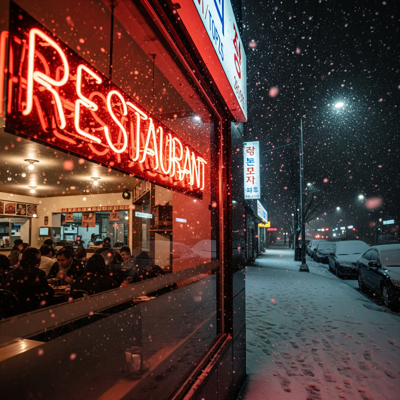

In [ ]:
prompt = """
사실적인 밤 장면
- 추운 거리에서 밝게 빛나는 고전적인 1980년대의 한국식 식당을 본다.
- 전체 시야는 눈이 내리는 큰 유리창을 통해 필터링 된다.
- 'Restaurant'이라는 네온 표지판이 유리창에 걸려 있다.
"""

image = client.models.generate_images(
    model=generation_model_ultra,
    prompt=prompt,
    config=GenerateImagesConfig(
        number_of_images=1,
        aspect_ratio="1:1",
        image_size="2K",
        safety_filter_level="BLOCK_LOW_AND_ABOVE",
        person_generation="ALLOW_ALL",
    ),
)

display_image(image.generated_images[0].image)

### 4. 다국어 지원 테스트

Imagen 4는 여러 언어로 된 텍스트 프롬프트 처리 가능
- 영어, 한국어, 일본어, 중국어, 힌디어, 포르투갈어, 스페인어, 독일어, 프랑스어, ...

`enhance_prompt` 매개변수를 'True'로 설정하게 되면 원본 프롬프트를 새롭고 자세한 프롬프트로 재작성
- 더 높은 품질의 이미지 생성 가능

Impressionistic oil painting of a coffee cup on a kitchen table. The cup is white ceramic with "Good Morning" written on it in a whimsical, playful font. Sunlight streams in from a nearby window, illuminating dust motes in the air and casting soft, blurry shadows. A half-eaten croissant and a small, vibrant blue saucer with a spoon rest beside the cup. The brushstrokes are loose and visible, especially in the background which features hints of a fruit bowl and a window frame, rendered in soft, blended colors. The overall mood is warm and inviting, capturing a fleeting moment of a morning scene.


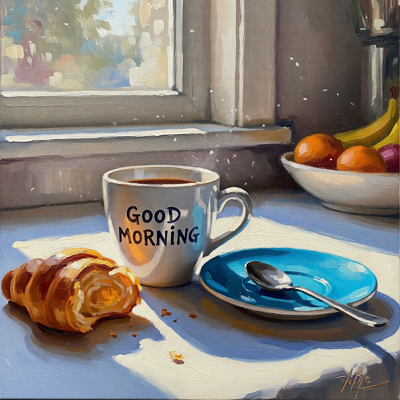

In [9]:
prompt = """
주방 테이블 위의 커피잔에 대한 인상주의 유화, 컵에 '좋은 아침'이라는 글자가 장난스러운 글꼴 작성되어 있다.
"""

image = client.models.generate_images(
    model=generation_model,
    prompt=prompt,
    config=GenerateImagesConfig(
        number_of_images=1,
        aspect_ratio="1:1",
        image_size="2K",
        enhance_prompt=True,
        safety_filter_level="BLOCK_LOW_AND_ABOVE",
        person_generation="ALLOW_ALL",
    ),
)

# Print the enhanced prompt
print(image.generated_images[0].enhanced_prompt)
display_image(image.generated_images[0].image)

### 5. 더 나은 텍스트 렌더링

Imagen 4는 이미지 내의 단어, 제목, 문구를 정확하게 렌더링하는 데 탁월한 성능을 보임
- 만화, 로고 생성, 순서도, 전단지, 포스터 등에 특히 유용

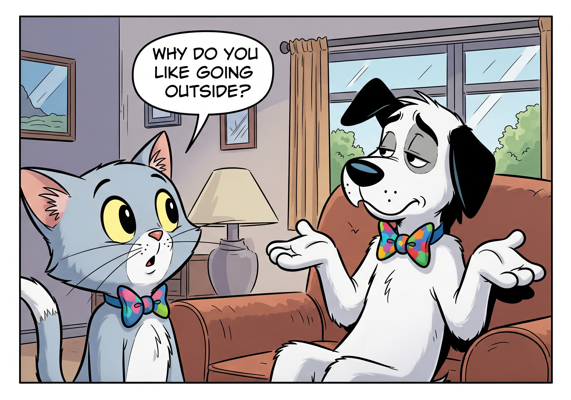

In [10]:
prompt = """
만화 스크립트의 한 장면이다.
- 귀여운 고양이가 강아지에게 말을 걸고 있다.
- 고양이는 이해가 되지 않는 표정을 가진 채로 "왜 나가는 것을 좋아해?"라고 질문한다.
- 강아지는 어깨를 으쓱하며 이해할 필요 없다는 표정으로 무시한다.
- 명확하게 표현된 그림으로 자신감 있는 선과 음영 처리가 되어 있다.
"""

image = client.models.generate_images(
    model=generation_model,
    prompt=prompt,
    config=GenerateImagesConfig(
        number_of_images=1,
        aspect_ratio="4:3",
        image_size="2K",
        safety_filter_level="BLOCK_LOW_AND_ABOVE",
        person_generation="ALLOW_ALL",
    ),
)

display_image(image.generated_images[0].image)

### 6. 이미지 워터마크 추가

기본적으로 Imagen 4 이미지에는 디지털 워터마크 또는 SynthID 가 추가됨
- `add_watermark` 매개변수를 'True'로 설정

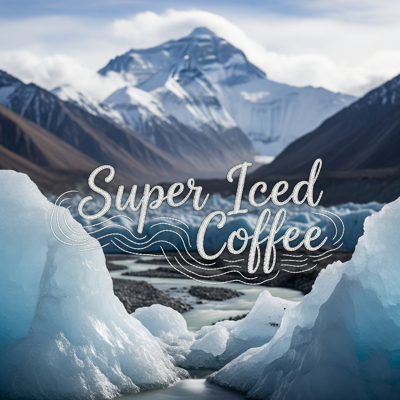

In [11]:
prompt = """
텀블러에 삽입 될 이미지를 디자인하라.
- 배경은 에베레스트 산이며, 초점은 흐리다.
- 산 아래에 계곡이 흐르고 있고, 얼음이 클로즈업 되어 있다.
- 그 얼음과 흐르는 물 사이에 'Super Iced Coffee'라는 텍스트가 있다.
- 텍스트의 타이포그래피는 흐르는 듯한 손바느질 자수 느낌이어야 한다.
"""

image = client.models.generate_images(
    model=generation_model,
    prompt=prompt,
    config=GenerateImagesConfig(
        number_of_images=1,
        aspect_ratio="1:1",
        image_size="2K",
        safety_filter_level="BLOCK_LOW_AND_ABOVE",
        person_generation="ALLOW_ALL",
        add_watermark=True,
    ),
)

display_image(image.generated_images[0].image)